In [1]:
import argparse
import torch
import torch.nn as nn
from tqdm import tqdm
from typing import Dict, Iterator

from torch.utils.data import DataLoader

from datasets.HMDB51Dataset import HMDB51Dataset
from models import model_creator
from utils import statistics

%load_ext autoreload
%autoreload 2

In [2]:
def create_datasets(
        frames_dir: str,
        annotations_dir: str,
        split: HMDB51Dataset.Split,
        clip_length: int,
        crop_size: int,
        temporal_stride: int,
        num_segments: int, 
        num_spatial_crops: int
) -> Dict[str, HMDB51Dataset]:
    """
    Creates datasets for training, validation, and testing.

    Args:
        frames_dir (str): Directory containing the video frames (a separate directory per video).
        annotations_dir (str): Directory containing annotation files.
        split (HMDB51Dataset.Split): Dataset split (TEST_ON_SPLIT_1, TEST_ON_SPLIT_2, TEST_ON_SPLIT_3).
        clip_length (int): Number of frames of the clips.
        crop_size (int): Size of spatial crops (squares).
        temporal_stride (int): Receptive field of the model will be (clip_length * temporal_stride) / FPS.

    Returns:
        Dict[str, HMDB51Dataset]: A dictionary containing the datasets for training, validation, and testing.
    """
    datasets = {}
    for regime in HMDB51Dataset.Regime:
        datasets[regime.name.lower()] = HMDB51Dataset(
            frames_dir,
            annotations_dir,
            split,
            regime,
            clip_length,
            crop_size,
            temporal_stride,
            num_segments, 
            num_spatial_crops
        )
    
    return datasets


def create_dataloaders(
        datasets: Dict[str, HMDB51Dataset],
        batch_size: int,
        batch_size_eval: int = 8,
        num_workers: int = 2,
        pin_memory: bool = True
    ) -> Dict[str, DataLoader]:
    """
    Creates data loaders for training, validation, and testing datasets.

    Args:
        datasets (Dict[str, HMDB51Dataset]): A dictionary containing datasets for training, validation, and testing.
        batch_size (int, optional): Batch size for the data loaders. Defaults to 8.
        num_workers (int, optional): Number of worker processes for data loading. Defaults to 2.
        pin_memory (bool, optional): Whether to pin memory in DataLoader for faster GPU transfer. Defaults to True.

    Returns:
        Dict[str, DataLoader]: A dictionary containing data loaders for training, validation, and testing datasets.
    """
    dataloaders = {}
    for key, dataset in datasets.items():
        dataloaders[key] = DataLoader(
            dataset,
            batch_size=(batch_size if key == 'training' else batch_size_eval),
            shuffle=(key == 'training'),  # Shuffle only for training dataset
            collate_fn=dataset.collate_fn,
            num_workers=num_workers,
            pin_memory=pin_memory
        )
            
    return dataloaders

parser = argparse.ArgumentParser(description='Train a video classification model on HMDB51 dataset.')

parser.frames_dir = "/ghome/group08/c6/week5/frames"
parser.annotations_dir = "/ghome/group08/c6/week5/data/hmdb51/testTrainMulti_601030_splits"
parser.clip_length = 16
parser.crop_size = 224
parser.temporal_stride = 5
parser.model_name = "x3d_m"
parser.load_pretrain = False
parser.num_workers = 2
parser.device = "cpu"
parser.batch_size = 16
parser.batch_size_eval = 16
parser.num_segments = 2
parser.num_spatial_crops = 3

args = parser

# Create datasets
datasets = create_datasets(
    frames_dir=args.frames_dir,
    annotations_dir=args.annotations_dir,
    split=HMDB51Dataset.Split.TEST_ON_SPLIT_1, # hardcoded
    clip_length=args.clip_length,
    crop_size=args.crop_size,
    temporal_stride=args.temporal_stride,
    num_segments=args.num_segments,
    num_spatial_crops=args.num_spatial_crops
)

# Create data loaders
loaders = create_dataloaders(
    datasets,
    args.batch_size,
    batch_size_eval=args.batch_size_eval,
    num_workers=args.num_workers
)

In [11]:
from utils import model_analysis
def print_model_summary(
        model: nn.Module,
        clip_length: int,
        crop_size: int,
        input_channel: int,
        print_model: bool = True,
        print_params: bool = True,
        print_FLOPs: bool = True
    ) -> None:
    """
    Prints a summary of the given model.

    Args:
        model (nn.Module): The model for which to print the summary.
        clip_length (int): Number of frames of the clips.
        crop_size (int): Size of spatial crops (squares).
        print_model (bool, optional): Whether to print the model architecture. Defaults to True.
        print_params (bool, optional): Whether to print the number of parameters. Defaults to True.
        print_FLOPs (bool, optional): Whether to print the number of FLOPs. Defaults to True.

    Returns:
        None
    """
    if print_model:
        print(model)

    if print_params:
        num_params = sum(p.numel() for p in model.parameters())
        #num_params = model_analysis.calculate_parameters(model) # should be equivalent
        print(f"Number of parameters (M): {round(num_params / 1e6, 2)}")

    if print_FLOPs:
        num_FLOPs = model_analysis.calculate_operations(model, clip_length, crop_size, crop_size, input_channel)
        print(f"Number of FLOPs (G): {round(num_FLOPs / 1e9, 2)}")

model = model_creator.create('x3d_m', False, 51, 2)
# print_model_summary(model, 16, 224, 3, print_model=False)

In [12]:
model.load_state_dict(torch.load('../pretrained/x3d_m_of.pth', map_location='cpu'))

<All keys matched successfully>

In [8]:
model.eval()

def aggregation_function(scores, num_segments, num_crops):
    total_n, n_classes = scores.shape
    batch_size = total_n // (num_segments * num_crops)

    aggregated_outputs = torch.zeros((batch_size, n_classes), device=scores.device)
    for i in range(batch_size):
        # Extract scores for each segment-crop combination
        segment_crop_scores = scores[i * num_segments * num_crops: (i + 1) * num_segments * num_crops]

        # Reshape scores to separate segments and crops
        segment_crop_scores = segment_crop_scores.reshape((num_segments, num_crops, n_classes))

        # Average scores across crops for each segment
        segment_scores = segment_crop_scores.mean(axis=1)

        # Aggregate scores across segments
        aggregated_outputs[i, :] = segment_scores.mean(axis=0)

    return aggregated_outputs

def evaluate(
        model: nn.Module, 
        valid_loader: DataLoader, 
        loss_fn: nn.Module,
        type_data: str,
        num_segments: int,
        num_spatial_crops: int,
        device: str,
        description: str = ""
    ) -> None:
    """
    Evaluates the given model using the provided data loader and loss function.

    Args:
        model (nn.Module): The neural network model to be validated.
        valid_loader (DataLoader): The data loader containing the validation dataset.
        loss_fn (nn.Module): The loss function used to compute the validation loss (not used for backpropagation)
        device (str): The device on which the model and data should be processed ('cuda' or 'cpu').
        description (str, optional): Additional information for tracking epoch description during training. Defaults to "".

    Returns:
        None
    """
    model.eval()
    pbar = tqdm(valid_loader, desc=description, total=len(valid_loader))
    loss_valid_mean = statistics.RollingMean(window_size=len(valid_loader))
    hits = count = 0 # auxiliary variables for computing accuracy
    all_labels = []
    all_predictions = []
    for batch in pbar:
        # Gather batch and move to device
        if type_data == "rgb":
            clips, labels = batch['clips'].to(device), batch['labels'].to(device)
        elif type_data == "of":
            clips, labels = valid_loader.dataset.get_of_batch(batch['clips']).to(device), batch['labels'].to(device)
        elif type_data == "both":
            clips_rgb, labels = batch['clips'].to(device), batch['labels'].to(device)
            clips_of = valid_loader.dataset.get_of_batch(clips_rgb).to(device)
            clips = torch.cat((clips_rgb, clips_of), dim=1)
        # Forward pass
        with torch.no_grad():
            outputs = model(clips)
            scores = torch.nn.functional.log_softmax(outputs, dim=-1)
            # Agregate outputs per video
            aggregated_outputs = aggregation_function(scores, num_segments, num_spatial_crops)
            # Compute loss (just for logging, not used for backpropagation)
            loss = loss_fn(aggregated_outputs, labels) 
            # Compute metrics
            loss_iter = loss.item()
            hits_iter = torch.eq(aggregated_outputs.argmax(dim=1), labels).sum().item()
            hits += hits_iter
            count += len(labels)
            # Update progress bar with metrics
            pbar.set_postfix(
                loss=loss_iter,
                loss_mean=loss_valid_mean(loss_iter),
                acc=(float(hits_iter) / len(labels)),
                acc_mean=(float(hits) / count)
            )
            # Save labels and predictions
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(aggregated_outputs.argmax(dim=1).cpu().numpy())
    return all_labels, all_predictions, loss_valid_mean(loss_iter), float(hits) / count

loss_fn = nn.CrossEntropyLoss()
all_labels, all_predictions, mean_loss, mean_acc  = evaluate(model, loaders['testing'], loss_fn, 'of', 2, 3, args.device, description=f"Testing")
print(f"Mean loss: {mean_loss:.4f}, Mean accuracy: {mean_acc:.4f}")

Testing:   0%|          | 0/95 [00:00<?, ?it/s]

Testing: 100%|██████████| 95/95 [46:02<00:00, 29.08s/it, acc=0.231, acc_mean=0.222, loss=2.42, loss_mean=3.23] 

Mean loss: 3.2371, Mean accuracy: 0.2221


In [3]:
# Calculate per-class accuracies for the baseline
from sklearn.metrics import accuracy_score
import pickle

with open('test_labels_of.pkl', 'rb') as f:
    all_labels = pickle.load(f)

with open('test_predictions_of.pkl', 'rb') as f:
    all_predictions = pickle.load(f)

unique_labels = set(all_labels)
class_accuracies_baseline = {}

for label in unique_labels:
    idxs = [i for i, x in enumerate(all_labels) if x == label]
    class_preds = [all_predictions[i] for i in idxs]
    class_labels = [all_labels[i] for i in idxs]
    class_accuracies_baseline[label] = accuracy_score(class_labels, class_preds)

print(class_accuracies_baseline)

{0: 0.36666666666666664, 1: 0.4666666666666667, 2: 0.23333333333333334, 3: 0.16666666666666666, 4: 0.16666666666666666, 5: 0.1, 6: 0.27586206896551724, 7: 0.20689655172413793, 8: 0.3, 9: 0.3333333333333333, 10: 0.2, 11: 0.3793103448275862, 12: 0.06666666666666667, 13: 0.8666666666666667, 14: 0.26666666666666666, 15: 0.3, 16: 0.16666666666666666, 17: 0.4827586206896552, 18: 0.20689655172413793, 19: 0.3103448275862069, 20: 0.2413793103448276, 21: 0.5, 22: 0.23333333333333334, 23: 0.10344827586206896, 24: 0.13333333333333333, 25: 0.06896551724137931, 26: 0.1, 27: 0.13333333333333333, 28: 0.5333333333333333, 29: 0.4, 30: 0.10344827586206896, 31: 0.20689655172413793, 32: 0.43333333333333335, 33: 0.5666666666666667, 34: 0.23333333333333334, 35: 0.4666666666666667, 36: 0.16666666666666666, 37: 0.4, 38: 0.4, 39: 0.36666666666666664, 40: 0.8666666666666667, 41: 0.4, 42: 0.3448275862068966, 43: 0.5666666666666667, 44: 0.3333333333333333, 45: 0.16666666666666666, 46: 0.3333333333333333, 47: 0.103

In [4]:
import pickle
with open('test_labels_agg.pkl', 'rb') as f:
    all_labels2 = pickle.load(f)

with open('test_predictions_agg.pkl', 'rb') as f:
    all_predictions2 = pickle.load(f)
# Calculate per-class accuracies for the new model
from sklearn.metrics import accuracy_score

unique_labels = set(all_labels2)
class_accuracies_new_model = {}

for label in unique_labels:
    idxs = [i for i, x in enumerate(all_labels2) if x == label]
    class_preds = [all_predictions2[i] for i in idxs]
    class_labels = [all_labels2[i] for i in idxs]
    class_accuracies_new_model[label] = accuracy_score(class_labels, class_preds)

print(class_accuracies_new_model)

{0: 0.5666666666666667, 1: 0.8333333333333334, 2: 0.0, 3: 0.2, 4: 0.1, 5: 0.43333333333333335, 6: 0.3103448275862069, 7: 0.1724137931034483, 8: 0.16666666666666666, 9: 0.7666666666666667, 10: 0.16666666666666666, 11: 0.3448275862068966, 12: 0.0, 13: 0.7333333333333333, 14: 0.4, 15: 0.7, 16: 0.23333333333333334, 17: 0.4482758620689655, 18: 0.0, 19: 0.5862068965517241, 20: 0.0, 21: 0.4666666666666667, 22: 0.23333333333333334, 23: 0.4827586206896552, 24: 0.13333333333333333, 25: 0.0, 26: 0.3, 27: 0.43333333333333335, 28: 0.3333333333333333, 29: 0.4, 30: 0.4482758620689655, 31: 0.20689655172413793, 32: 0.43333333333333335, 33: 0.9, 34: 0.36666666666666664, 35: 0.43333333333333335, 36: 0.3, 37: 0.23333333333333334, 38: 0.5, 39: 0.3, 40: 0.36666666666666664, 41: 0.2, 42: 0.5517241379310345, 43: 0.2, 44: 0.43333333333333335, 45: 0.03333333333333333, 46: 0.4666666666666667, 47: 0.06896551724137931, 48: 0.1, 49: 0.0, 50: 0.23333333333333334}


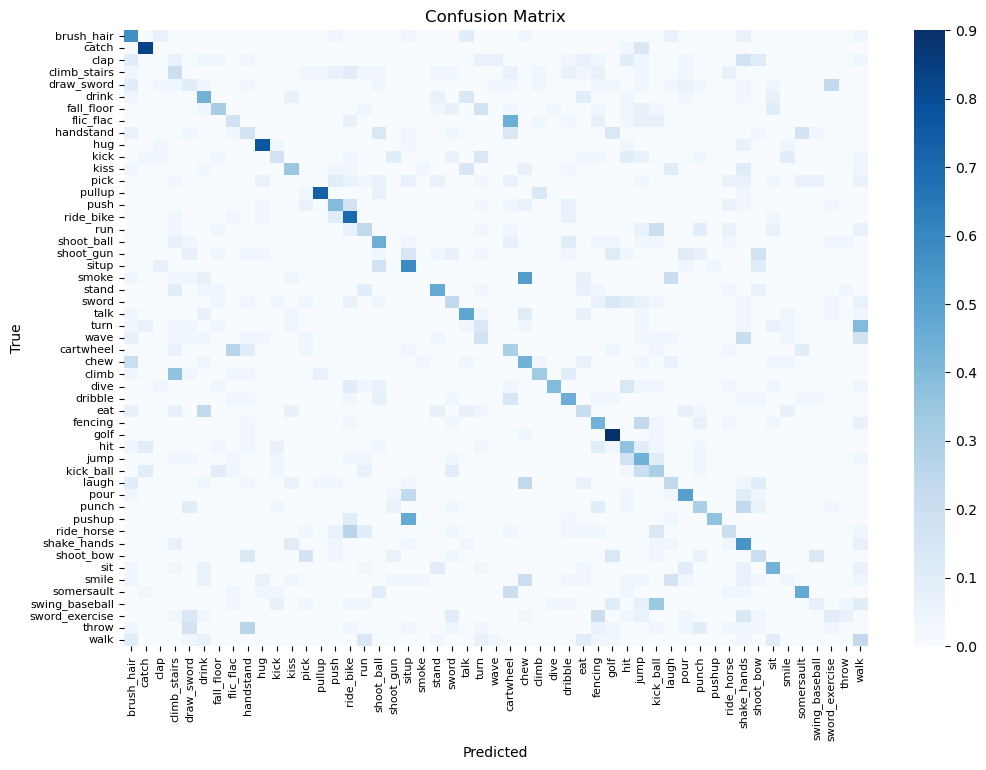

High misclassification from flic_flac to cartwheel: 0.4482758620689655
High misclassification from smoke to chew: 0.5172413793103449
High misclassification from turn to walk: 0.4
High misclassification from climb to climb_stairs: 0.36666666666666664
High misclassification from pushup to situp: 0.4666666666666667
High misclassification from swing_baseball to kick_ball: 0.3448275862068966


In [5]:
# PLOT CONFUSION MATRIX
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

class_names = datasets["training"].CLASS_NAMES

cm = confusion_matrix(all_labels2, all_predictions2)
cm = cm / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=False, cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.title('Confusion Matrix')
plt.show()

def highlight_errors(confusion_matrix, class_names):
    np.fill_diagonal(confusion_matrix, 0)  # Ignore diagonal elements (true positives)
    high_error_indices = np.where(confusion_matrix > np.percentile(confusion_matrix, 95))
    for row, col in zip(*high_error_indices):
        if confusion_matrix[row, col] > 0.3:
            print(f"High misclassification from {class_names[row]} to {class_names[col]}: {confusion_matrix[row, col]}")

highlight_errors(cm, class_names)

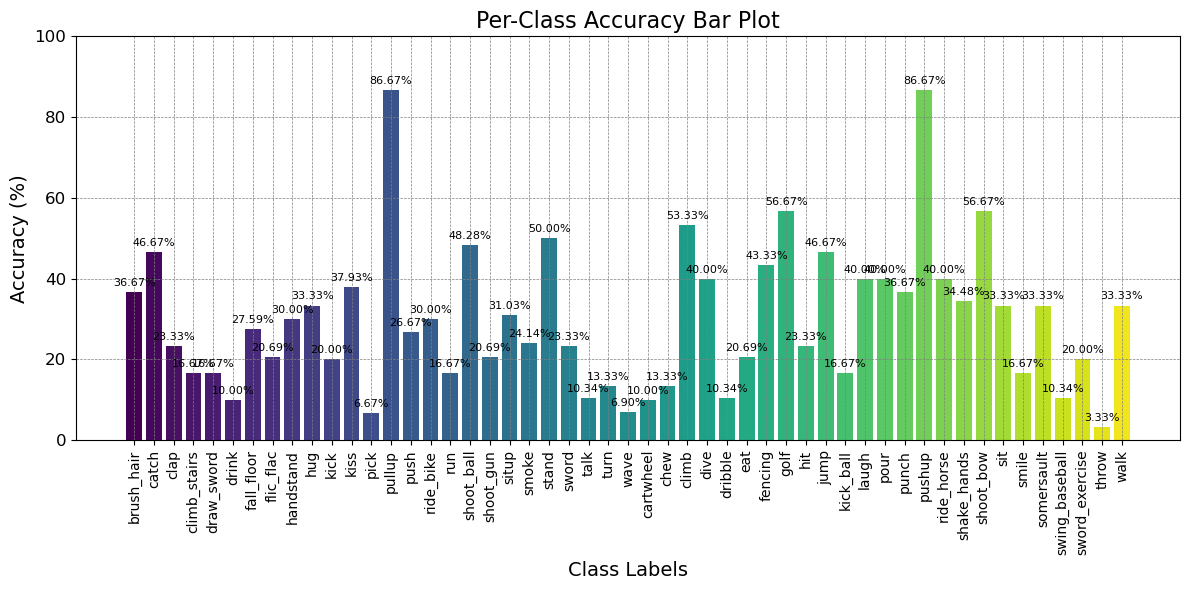

In [59]:
import matplotlib.pyplot as plt

class_names = datasets["training"].CLASS_NAMES

labels = list(class_accuracies_baseline.keys())
accuracies = [class_accuracies_baseline[lbl] * 100 for lbl in labels]  # Convert fractions to percentages

# Use a visually appealing color scheme, such as a sequential palette
colors = plt.cm.viridis([i/len(labels) for i in range(len(labels))])

# Create a professional looking bar plot
plt.figure(figsize=(12, 6))
bars = plt.bar(class_names, accuracies, color=colors)
plt.xlabel('Class Labels', fontsize=14)
plt.ylabel('Accuracy (%)', fontsize=14)
plt.title('Per-Class Accuracy Bar Plot', fontsize=16)
plt.xticks(rotation=90, fontsize=10)  # Rotate class labels for better visibility
plt.yticks(fontsize=12)
plt.ylim(0, 100)  # Set y-axis to show percentage
plt.grid(True, which='major', linestyle='--', linewidth='0.5', color='grey')  # Add gridlines
plt.tight_layout()  # Adjust layout to make room for label rotation

# Optional: Adding value labels on bars
for bar in bars:
    yval = bar.get_height()
    if yval > 0:
        plt.text(bar.get_x() + bar.get_width()/2, yval + 1, f'{yval:.2f}%', ha='center', va='bottom', fontsize=8, rotation=0)

plt.show()

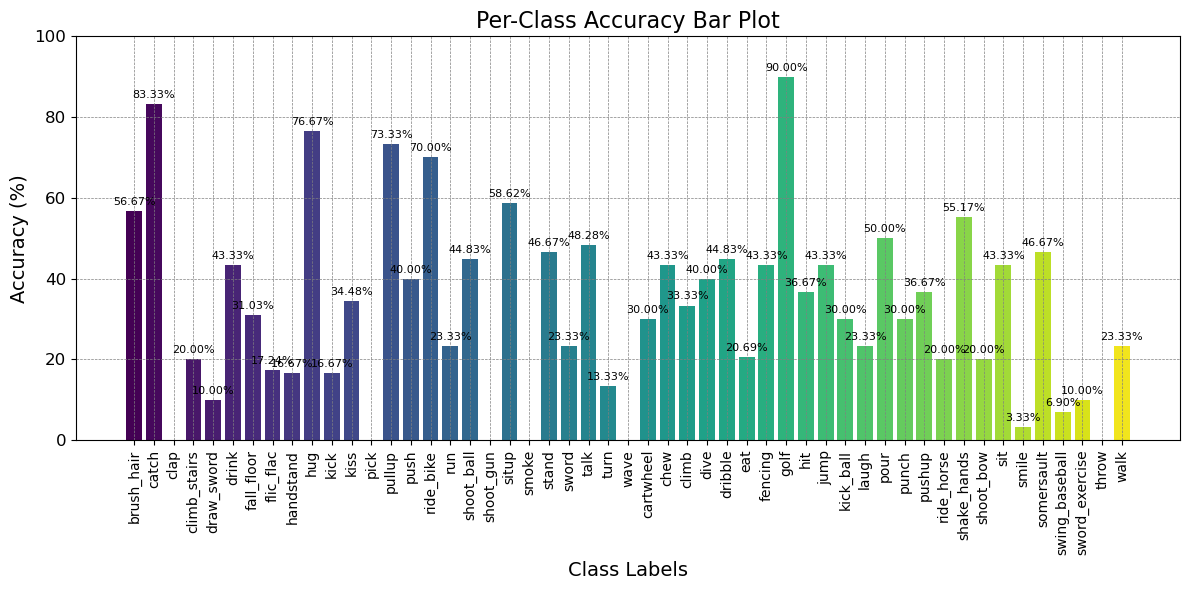

In [6]:
import matplotlib.pyplot as plt

class_names = datasets["training"].CLASS_NAMES

labels = list(class_accuracies_new_model.keys())
accuracies = [class_accuracies_new_model[lbl] * 100 for lbl in labels]  # Convert fractions to percentages

# Use a visually appealing color scheme, such as a sequential palette
colors = plt.cm.viridis([i/len(labels) for i in range(len(labels))])

# Create a professional looking bar plot
plt.figure(figsize=(12, 6))
bars = plt.bar(class_names, accuracies, color=colors)
plt.xlabel('Class Labels', fontsize=14)
plt.ylabel('Accuracy (%)', fontsize=14)
plt.title('Per-Class Accuracy Bar Plot', fontsize=16)
plt.xticks(rotation=90, fontsize=10)  # Rotate class labels for better visibility
plt.yticks(fontsize=12)
plt.ylim(0, 100)  # Set y-axis to show percentage
plt.grid(True, which='major', linestyle='--', linewidth='0.5', color='grey')  # Add gridlines
plt.tight_layout()  # Adjust layout to make room for label rotation

# Optional: Adding value labels on bars
for bar in bars:
    yval = bar.get_height()
    if yval > 0:
        plt.text(bar.get_x() + bar.get_width()/2, yval + 1, f'{yval:.2f}%', ha='center', va='bottom', fontsize=8, rotation=0)

plt.show()

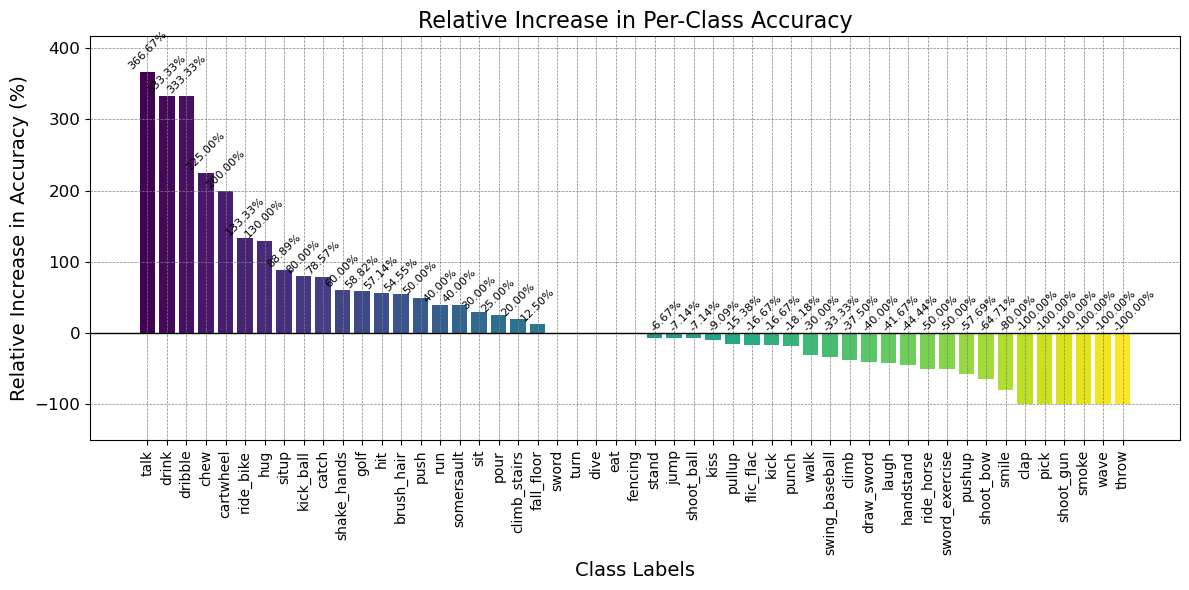

In [7]:
# Example data
class_accuracies_model1 = class_accuracies_baseline
class_accuracies_model2 = class_accuracies_new_model
#class_accuracies_model2 = {k: v + 0.1 for k, v in class_accuracies_baseline.items()} # CHANGE THIS TO YOUR OWN DATA (PREVIOUS LINE)

# Calculating relative increase in accuracy
relative_increase = {}
for lbl in class_accuracies_baseline.keys():
    initial = class_accuracies_baseline[lbl]
    new = class_accuracies_model2[lbl]
    if initial != 0:
        increase = (new - initial) / initial * 100
    else:
        increase = 0
    relative_increase[lbl] = increase

# Assuming class names as labels
class_names = datasets["training"].CLASS_NAMES

# Sort the increase and labels accordingly
sorted_items = sorted(relative_increase.items(), key=lambda x: x[1], reverse=True)
sorted_labels, sorted_increases = zip(*sorted_items)
sorted_names = [class_names[lbl] for lbl in sorted_labels]

# Use a visually appealing color scheme
colors = plt.cm.viridis(np.linspace(0, 1, len(sorted_labels)))

# Create a professional looking bar plot
plt.figure(figsize=(12, 6))
bars = plt.bar(sorted_names, sorted_increases, color=colors)
plt.xlabel('Class Labels', fontsize=14)
plt.ylabel('Relative Increase in Accuracy (%)', fontsize=14)
plt.title('Relative Increase in Per-Class Accuracy', fontsize=16)
plt.xticks(rotation=90, fontsize=10)
plt.yticks(fontsize=12)
plt.ylim(min(sorted_increases) - 50, max(sorted_increases) + 50)
plt.grid(True, which='major', linestyle='--', linewidth='0.5', color='grey')
plt.tight_layout()
plt.axhline(y=0.0, color='black', linewidth=1, linestyle='-')

# Adding value labels on bars
for bar in bars:
    yval = bar.get_height()
    if yval != 0:
        horizontal_offset = bar.get_width()/2 if yval > 0 else 1.25*bar.get_width()
        vertical_offset = yval + 1 if yval > 0 else 0
        plt.text(bar.get_x() + horizontal_offset, vertical_offset, f'{yval:.2f}%', ha='center', va='bottom', fontsize=8, rotation=45)

plt.show()

/ghome/group08/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/ghome/group08/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Raft_Large_Weights.C_T_SKHT_V2`. You can also use `weights=Raft_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


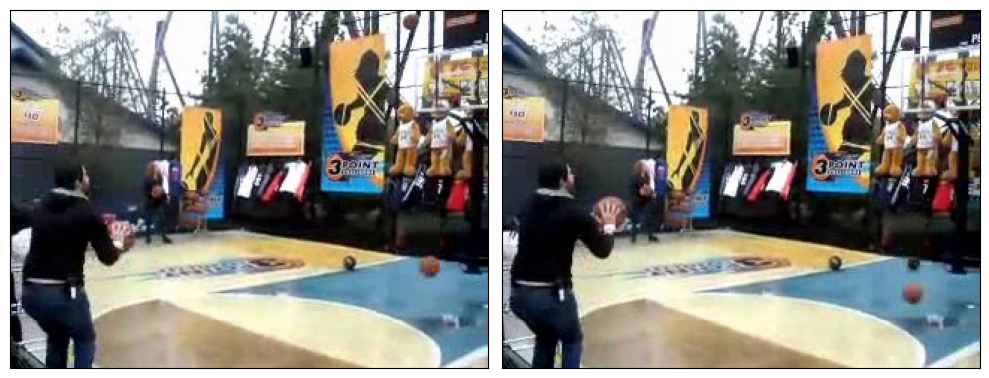

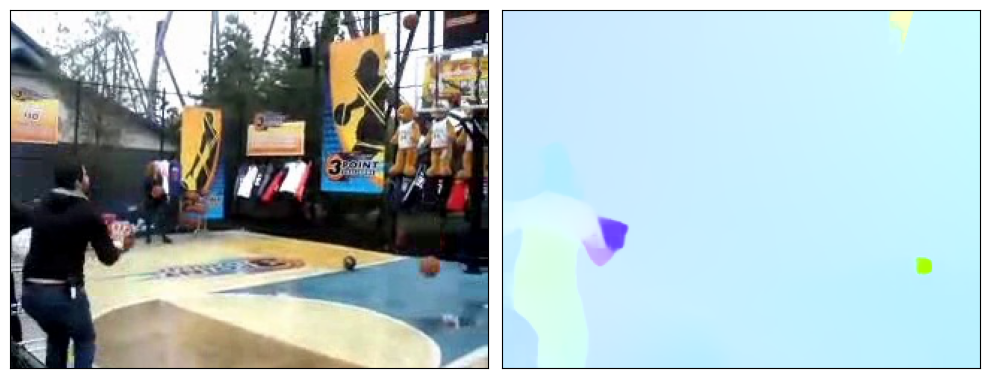

In [55]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F
import torchvision.transforms as T

plt.rcParams["savefig.bbox"] = "tight"

def plot(imgs, **imshow_kwargs):
    if not isinstance(imgs[0], list):
        # Make a 2d grid even if there's just 1 row
        imgs = [imgs]

    num_rows = len(imgs)
    num_cols = len(imgs[0])
    _, axs = plt.subplots(nrows=num_rows, ncols=num_cols, squeeze=False, figsize=(5 * num_cols, 5 * num_rows))
    for row_idx, row in enumerate(imgs):
        for col_idx, img in enumerate(row):
            ax = axs[row_idx, col_idx]
            img = F.to_pil_image(img.to("cpu"))
            ax.imshow(np.asarray(img), **imshow_kwargs)
            ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

    plt.tight_layout()

def preprocess(batch):
    transforms = T.Compose(
        [
            T.ConvertImageDtype(torch.float32),
            T.Normalize(mean=0.5, std=0.5),  # map [0, 1] into [-1, 1]
            # T.Resize(size=(520, 960)),
        ]
    )
    batch = transforms(batch)
    return batch

# Load two example frames
from PIL import Image
i = 19
img1_batch = Image.open(f"/ghome/group08/c6/week5/frames/shoot_ball/WeTheKingsplaying_shoot_ball_f_cm_np1_ri_med_0/frame000{i}.jpg")
img2_batch = Image.open(f"/ghome/group08/c6/week5/frames/shoot_ball/WeTheKingsplaying_shoot_ball_f_cm_np1_ri_med_0/frame000{i+2}.jpg")

# convert to tensor
img1_batch = F.to_tensor(img1_batch)
img2_batch = F.to_tensor(img2_batch)

# Add batch dimension
img1_batch = img1_batch.unsqueeze(0)
img2_batch = img2_batch.unsqueeze(0)

plot([img1_batch[0], img2_batch[0]])

# If you can, run this example on a GPU, it will be a lot faster.
device = "cuda" if torch.cuda.is_available() else "cpu"

img1_batch = preprocess(img1_batch).to(device)
img2_batch = preprocess(img2_batch).to(device)

from torchvision.models.optical_flow import raft_large
device = 'cpu'

model = raft_large(pretrained=True, progress=False).to(device)
model = model.eval()

with torch.no_grad():
    list_of_flows = model(img1_batch.to(device), img2_batch.to(device))

predicted_flows = list_of_flows[-1]
from torchvision.utils import flow_to_image

flow_imgs = flow_to_image(predicted_flows)

# The images have been mapped into [-1, 1] but for plotting we want them in [0, 1]
img1_batch = [(img1 + 1) / 2 for img1 in img1_batch]

grid = [[img1, flow_img] for (img1, flow_img) in zip(img1_batch, flow_imgs)]
plot(grid)

In [38]:
import torchvision
frames = [torchvision.io.read_image(f"/ghome/group08/c6/week5/frames/shoot_ball/WeTheKingsplaying_shoot_ball_f_cm_np1_ri_med_0/frame000{i}.jpg") for i in range(10, 80, 2)]

In [42]:
from torchvision.io import write_jpeg
for i, (img1, img2) in enumerate(zip(frames, frames[1:])):
    # Note: it would be faster to predict batches of flows instead of individual flows
    img1 = preprocess(img1[None]).to(device)
    img2 = preprocess(img2[None]).to(device)

    with torch.no_grad():
        list_of_flows = model(img1, img2)
    predicted_flow = list_of_flows[-1][0]
    flow_img = flow_to_image(predicted_flow).to("cpu")
    write_jpeg(flow_img, f"gif/predicted_flow_{i}.jpg")

for i, (img1, img2) in enumerate(zip(frames, frames[1:])):
    write_jpeg(img1, f"gif/frame{i}.jpg")

In [48]:
batch_flows[-1].shape

torch.Size([34, 2, 240, 320])

In [45]:
processed_frames = torch.stack([preprocess(frame[None]) for frame in frames]).to(device)

# Batch the frames into pairs
img1s = processed_frames[:-1].squeeze(1)
img2s = processed_frames[1:].squeeze(1)

# Compute optical flows in batches
with torch.no_grad():
    batch_flows = model(img1s, img2s)

In [52]:
flow_img = flow_to_image(batch_flows[-1])
for i, flow_img in enumerate(flow_img):
    write_jpeg(flow_img, f"gif/predicted_flow_{i}.jpg")